# Tutorial bar classification with CNNs 

In this assignment, we will work with imaging data. In this notebook, you need to train a neural network to approach the bar and non-bar galaxy classification problem. 

We require you to train at least one network (ideally two different models). It could be constructed from scratch or adopting a transfer learning approach.

For each trained network, we ask you to save the best weights and models, and to submit them with your notebook. 

Using the best weights and models, we ask you to make predictions on unlabelled HSC images and analyse possible correlation between the bar/non-bar classification and the physical properties of galaxies, such as stellar mass, AGN luminosity, and star formationr rates. 

At the end, you should discuss what you did in this project and present the results. 

In [1]:
## Verify the system is correctly configured

moduleNames = [
    "numpy",
    "scipy",
    "pandas",
    "seaborn",
    "astropy",
    "sklearn",
    "tensorflow",
    "matplotlib",
    "tensorflow_datasets",
]
modules = map(__import__, moduleNames)

for m in modules:
    print(m.__name__, m.__version__)

numpy 1.26.3
scipy 1.12.0
pandas 2.2.0
seaborn 0.13.1
astropy 5.3.4
sklearn 1.4.0


2024-06-18 15:20:39.758649: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 15:20:39.763606: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-18 15:20:39.822874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 15:20:41.971657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow 2.16.1
matplotlib 3.8.2
tensorflow_datasets 4.9.5


## Import

## Path

In [119]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from astropy.io import ascii
from astropy.table import Table
from astropy.io import fits
from pathlib import Path
from numpy.random import randint
import math

import urllib.request

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Dropout
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
import tensorflow_datasets as tfds
from tensorflow.keras.applications import *
from tqdm import tqdm
import math
import shutil
from skimage.transform import resize

from tensorflow.keras.layers import Input, LeakyReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers


from sklearn import svm, datasets, metrics
from sklearn.model_selection import train_test_split

from astropy.table import Table

# from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams.update({"font.size": 18})

### NOTE:
So I'm apparently very bad at reading and/or got started too hastily and I completely missed that we had to also plot our loss and ROC during the training. I really did not want to have to train my models again and I fear that I did not save the training history, so I hope the accuracy training curve is okay. I also did not know how to save the best weights of the model, that's why I just saved my model as a .keras file since I believe this should also give you access to the final weights that were used. 

### Paths

In [120]:
base_dir = "/Users/users/asselt/ADS/"
bulk_dir = "/Users/users/asselt/dataserver/BULK/ADS/"
data_dir = "/Users/users/asselt/dataserver/BULK/ADS/GZ_DECaLS/"
pred_dir = "/Users/users/asselt/dataserver/BULK/ADS/CNN_pred/"

# 2. Filter out bad images
We first loop over all our images and filter out any images that might have any NaN values or infinite values

We then decide on the fraction we want to take when it comes to classifying our barred and unbarred galaxies. For this problem the unbarred fraction was set at anything above 0.7 and for the barred galaxies this was set at 0.5. These fractions were chosen to still keep a relatively clean dataset (>=0.7 votes in agreement) while also making sure there is enough data to train the model on. There were significantly less barred galaxies in the dataset, hence why the fraction for this was also set a little lower.

We've also plotted a sample of both the barred and the unbarred galaxies to see how well the classes seem to match


In [5]:
#Filter out nans
#Get names from downloaded files
names_glob=[path.stem for path in list(Path(data_dir).glob("*"))]

#Change to correct path
os.chdir(data_dir)
nan_list=[]

#Loop over images and filter out any nans
for name in tqdm(names_glob):
    hdulist= fits.open(data_dir+name+".fits")
    dat = hdulist[1].data
    if np.any(np.isnan(dat))==True:
        ! rm name+".fits"
        nan_list.append(name)
    elif np.any(np.isinf(dat))==True:
        ! rm name+".fits"
        nan_list.append(name)
    

100%|██████████| 7626/7626 [01:24<00:00, 89.98it/s] 


## Visualize the data

Plot a bunch of images with their corresponding labels as title.

In [121]:
Data_labels = Table.read(base_dir+"gz_decals_volunteers_1_and_2.csv").to_pandas()

In [122]:
Data_labels.columns

Index(['iauname', 'ra', 'dec', 'redshift', 'elpetro_absmag_r', 'sersic_nmgy_r',
       'petro_th50', 'petro_th90', 'petro_theta', 'upload_group',
       ...
       'merging_tidal-debris_fraction', 'merging_tidal-debris_debiased',
       'merging_both', 'merging_both_fraction', 'merging_both_debiased',
       'merging_neither', 'merging_neither_fraction',
       'merging_neither_debiased', 'wrong_size_statistic',
       'wrong_size_warning'],
      dtype='object', length=115)

In [123]:
#Get names from downloaded files
names_glob_filter=[path.stem for path in list(Path(data_dir).glob("*"))]

print(len(names_glob_filter))

7626


In [124]:
#Filter out entries for with we do not have the .fits file
Data_in_path= Data_labels[Data_labels["iauname"].isin(names_glob_filter)]
#Filter for useful columns
Useful_columns=["iauname","ra","dec","redshift",'elpetro_absmag_r',"bar_yes_fraction","bar_no_fraction"]
table_img= Data_in_path[Useful_columns]

In [125]:
#Get a list of strong, weak and no bars classification to plot
#Take the cut-off at 50% for bars and 70% for no bars
yes_bar= table_img[table_img["bar_yes_fraction"]>=0.5]
no_bar= table_img[table_img["bar_no_fraction"]>=0.7]

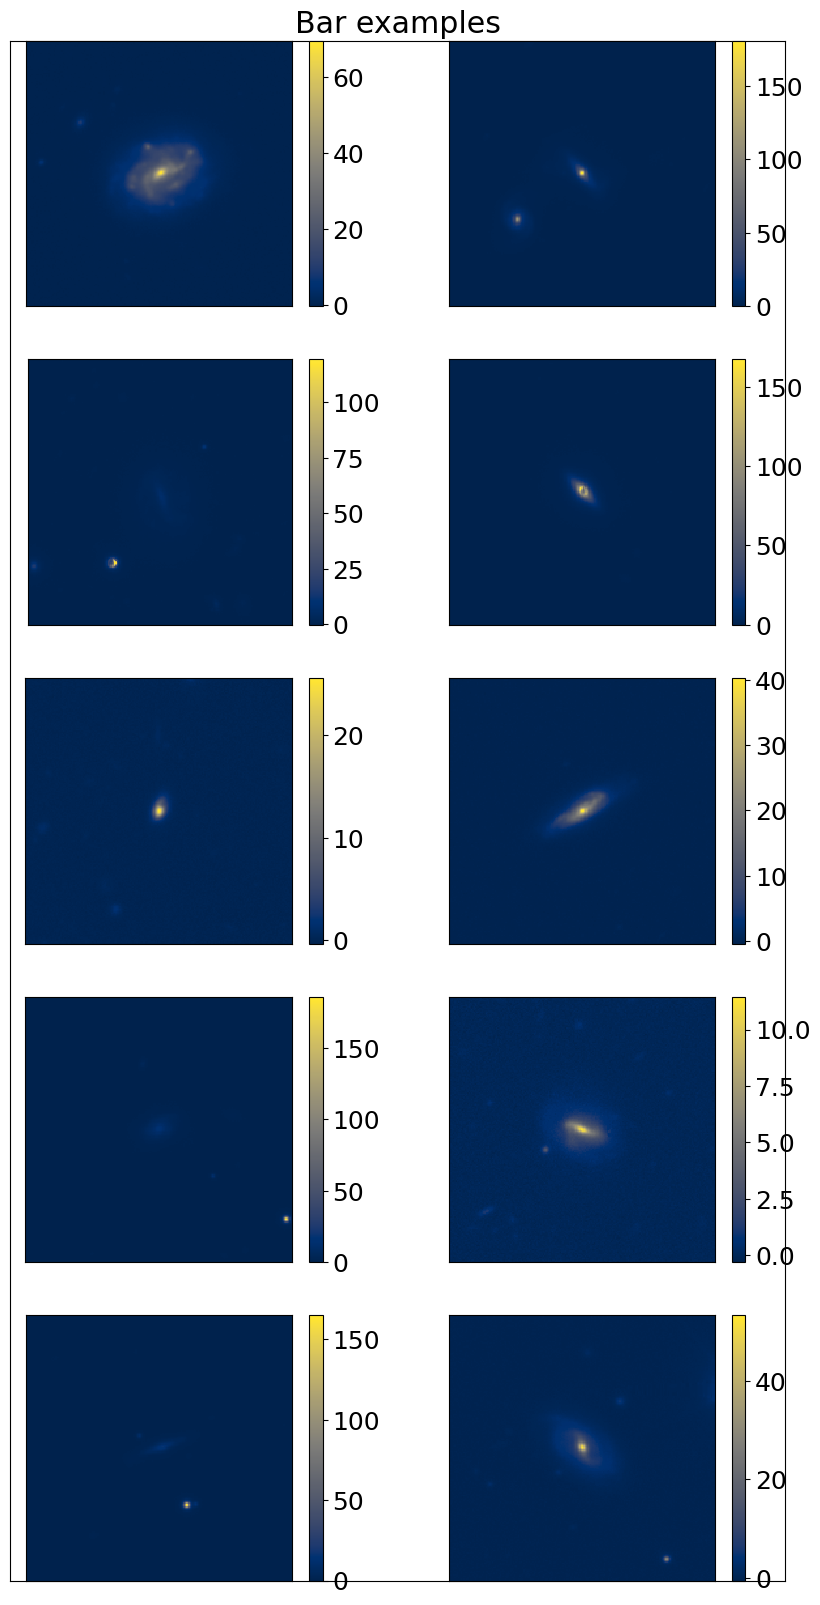

In [10]:
#sample 10 strong bars
sample_strong= yes_bar["iauname"].sample(10)

plt.figure(figsize=(10,20))
plt.title("Bar examples")
plt.xticks([])
plt.yticks([])
for i,name in enumerate(sample_strong):
    hdulist= fits.open(data_dir+name+".fits")
    dat = hdulist[1].data
    plt.subplot(5,2,i+1)
    im= plt.imshow(dat, interpolation='none', origin="lower", cmap='cividis')
    plt.colorbar(im)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


plt.show()
    

The plots above show that some galaxies are very easily identified by eye as a barred galaxy while some are a little more challenging. Quite a few of the images have other bright sources around it that wash our galaxy. I did not do any further cleaning of the dataset with an eye on time but some possiblities would have been to provide a smaller cut-out of our galaxies or to filter out any objects that are clearly a lot brighter than a galaxy would be (value of 100+). The latter would need some more careful consideration as you also do not want to clean your images too much as this would then make it difficult to use it for classification later on.

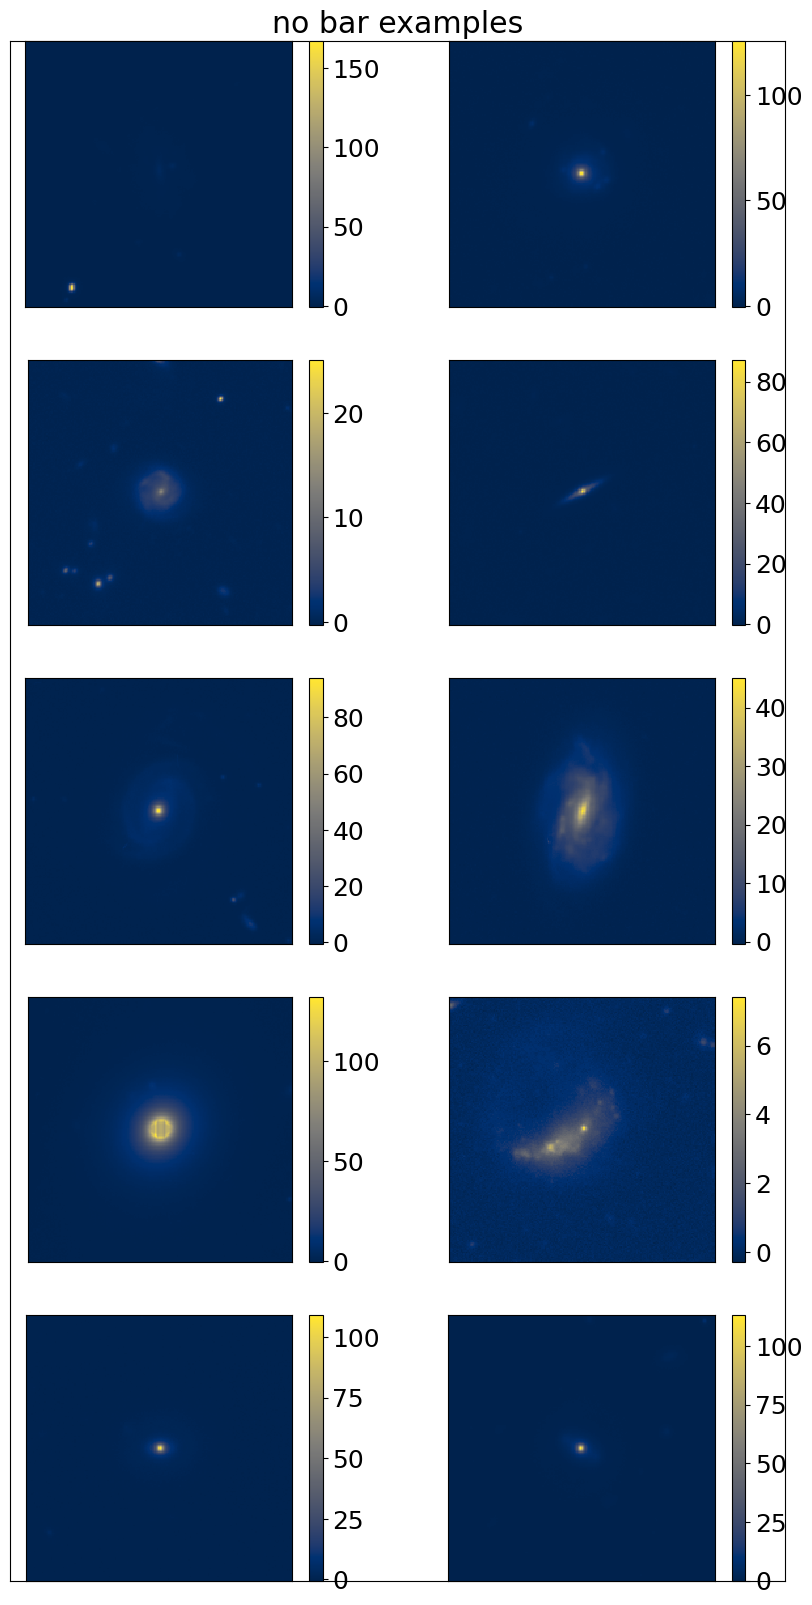

In [130]:
#sample 10 no bars
sample_no= no_bar["iauname"].sample(10)

plt.figure(figsize=(10,20))
plt.title("no bar examples")
plt.xticks([])
plt.yticks([])
for i,name in enumerate(sample_no):
    hdulist= fits.open(data_dir+name+".fits")
    dat = hdulist[1].data
    plt.subplot(5,2,i+1)
    im= plt.imshow(dat, interpolation='none', origin="lower", cmap='cividis')
    plt.colorbar(im)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


plt.show()
    

The unbarred sample shows some objects that appear a lot brighter than any of the galaxies in the barred selection. It also shows some very hard to resolve or edge-on objects. I'm not sure we can confidently say that these galaxies are unbarred but since the main goal of this model is to identify barred galaxies, the unbarred set is suffiently clean if it just does not contain any galaxies that are very clearly barred.  

<function matplotlib.pyplot.show(close=None, block=None)>

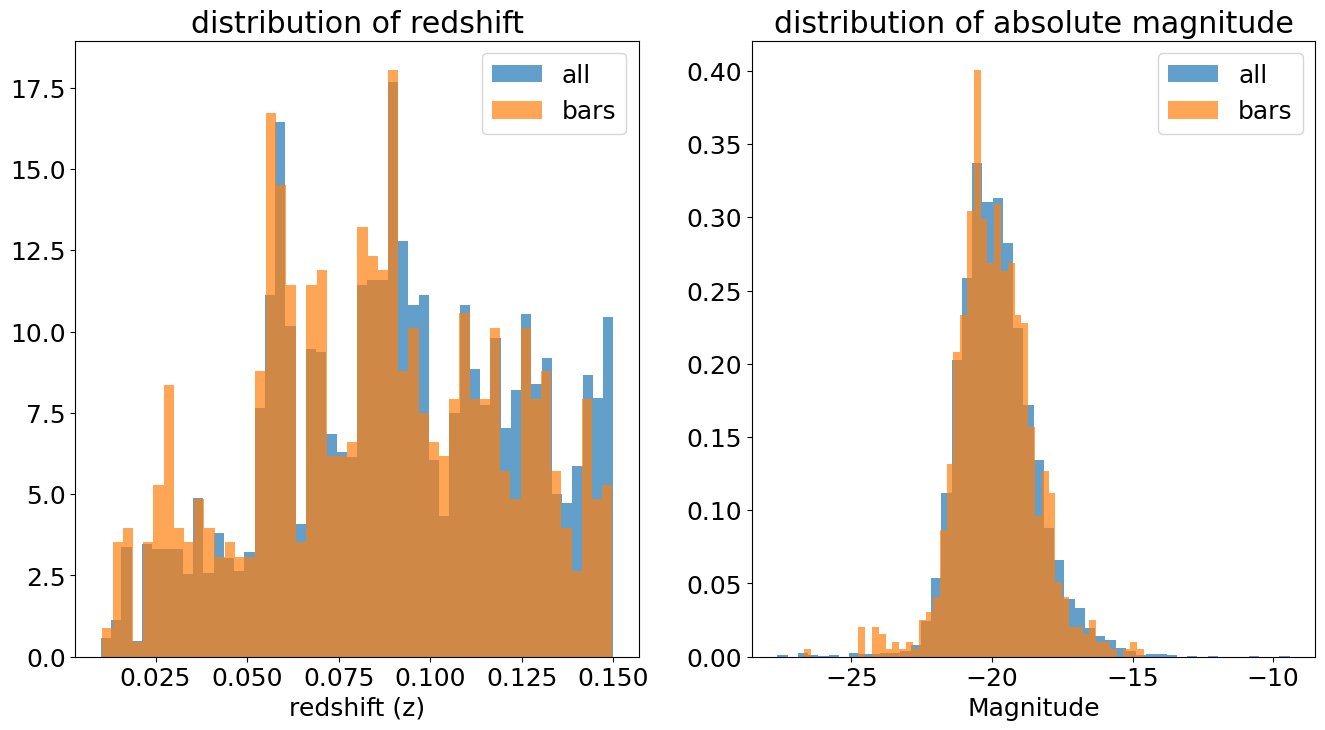

In [147]:
table_plot= table_img.replace([np.inf, -np.inf], np.nan)
table_plot.dropna(inplace=True)

fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2)
ax[0].hist(table_plot['redshift'],label="all",alpha=0.7,density=True,bins=50)
ax[0].hist(yes_bar['redshift'],label="bars",alpha=0.7,density=True,bins=50)
ax[0].set_xlabel("redshift (z)")
ax[0].legend()
ax[0].set_title("distribution of redshift")
ax[1].hist(table_plot['elpetro_absmag_r'],label="all",alpha=0.7,density=True,bins=50)
ax[1].hist(yes_bar['elpetro_absmag_r'],label="bars",alpha=0.7,density=True,bins=50)
ax[1].set_xlabel("Magnitude")
ax[1].legend()
ax[1].set_title("distribution of absolute magnitude")
plt.show

The sample of bars seems representative of the general distribution of the galaxy properties

# 3. Generate a Datasets for tensorflow

https://www.tensorflow.org/datasets/add_dataset

Load the Train and Validation dataset using a 20% split. 

First we rename all of our images to start with their class (Yb_) for barred and (Nb_) for unbarred

In [13]:
# #Rename data and move
os.chdir(bulk_dir)
names_noclass=[]
for name in tqdm(names_glob_filter):
    start_name= (data_dir+name+".fits")
    if np.any(table_img[table_img["iauname"]==name]["bar_yes_fraction"]>=0.7):
        dst= bulk_dir+"GZ_DECaLS_renamed/Yb_"+name+".fits"
        shutil.copy(start_name, dst)
    elif np.any(table_img[table_img["iauname"]==name]["bar_no_fraction"]>=0.7):
        dst= bulk_dir+"GZ_DECaLS_renamed/Nb_"+name+".fits"
        shutil.copy(start_name, dst)
    else:
        names_noclass.append(name)
    


100%|██████████| 7626/7626 [02:23<00:00, 53.11it/s] 


In [14]:
print(len(names_noclass))

1680


In [132]:
img_dir=bulk_dir+'GZ_DECaLS_renamed/'
names_bars= [path.stem for path in list(Path(img_dir).glob("Yb*"))]
names_nbars= [path.stem for path in list(Path(img_dir).glob("Nb*"))]
print(f"The ratio of barred/unbarred galaxies is {len(names_bars)/len(names_nbars)} ")

The ratio of barred/unbarred galaxies is 0.04591029023746702 


We then split our data up into train-val-test folders. This is done separately for barred and unbarred galaxies. We do this because we have such a small fraction of barred galaxies and we do not want any of sets to end up without (or hardly) any barred galaxies.

Another datapreperation step we take is to normalise our data to have pixel values between 0 and 1. After this we resize our data to (200,200,1) so that they are all the same size in preparation for our model.

I should have done the resizing before normalizing the data since it will not be properly normalised after resizing but I realised this a little bit late. Since we only resize our images from 203,204 to 200,200 and we prepare all of our data in the same way this should not make much of a difference in our training and classification results. It would only be an issue if some of the images were very different sizes but that should not be the case. 

Also note that the data here is reshaped to 200 x 200 but the first model was actually trained on data that was resized to 128 x 128

In [15]:
#Normalise the data and split it into train - val - test
img_dir=bulk_dir+'GZ_DECaLS_renamed/'
dst_train= bulk_dir+"train_img/"
dst_val= bulk_dir+"val_img/"
dst_test= bulk_dir+"test_img/"
names_bars= [path.stem for path in list(Path(img_dir).glob("Yb*"))]
names_nbars= [path.stem for path in list(Path(img_dir).glob("Nb*"))]

    
def norm_class(class_list, dst):
    """Normalises list of images and writes it to the desired directory"""
    for name in tqdm(class_list):
        dst_img=img_dir+name+".fits"

        hdulist= fits.open(dst_img)

        #extract image data
        dat = hdulist[1].data
        hdr = hdulist[1].header

        #Replace any NaN values with the mean
        med = np.nanmean(dat)
        dat = np.nan_to_num(dat, nan=med)
#         print(np.shape(dat))

        #Normalise data to values 0-1
        mini = np.min(dat)
        maxi = np.max(dat)
        datnorm = (dat-mini)/(maxi-mini)
#         print(np.shape(datnorm))

        hdulist[1].data = resize(datnorm,(200,200,1))
        dst_path= dst+name+".fits"
#         hdulist.writeto(dst_path, overwrite= True)
        
#Split no bars
nb_trainval,nb_test= train_test_split(names_nbars, test_size=0.2)
nb_train,nb_val=train_test_split(nb_trainval, test_size=0.2)

norm_class(nb_test,dst_test)
norm_class(nb_train,dst_train)
norm_class(nb_val,dst_val)

#Split bars
b_trainval,b_test= train_test_split(names_bars, test_size=0.2)
b_train,b_val=train_test_split(b_trainval, test_size=0.2)

norm_class(b_test,dst_test)
norm_class(b_train,dst_train)
norm_class(b_val,dst_val)

100%|██████████| 42/42 [00:02<00:00, 15.22it/s]


Load the generated dataset

In [3]:
tfds_name = "dataset_channels_last:1.0.0"
datasets_path = '/Users/users/asselt/tensorflow_datasets/'
batch_size = 300

In [4]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    tfds_name,
    data_dir=datasets_path,
    split=["train", "val", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

dataset_size = ds_info.splits["train"].num_examples
print("Num_examples dataset:", dataset_size)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(dataset_size)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Num_examples dataset: 3804


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking.

In [5]:
ds_train = ds_train.prefetch(buffer_size=16)
ds_val = ds_val.prefetch(buffer_size=16)
ds_test = ds_test.prefetch(buffer_size=16)

___

# 4. Build the model 1

The model below is a fairly basic "dummy" model to compare our later results to

In [48]:
def CNN1(input_size):
    """"Basic test"""
    CNN = models.Sequential()
    CNN.add(layers.Conv2D(32, (5, 5),activation='relu', input_shape=input_size))
    CNN.add(layers.Conv2D(32, (3, 3),activation='relu'))
    CNN.add(layers.MaxPooling2D((2, 2)))
    CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
    CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
    CNN.add(layers.MaxPooling2D((2, 2)))
    CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
    CNN.add(layers.Conv2D(128, (1, 1), activation='relu'))

    CNN.add(layers.Flatten())
    CNN.add(layers.Dense(64, activation='relu'))
    CNN.add(layers.Dense(1))
    CNN.summary()

    CNN.compile(optimizer='adam',
                loss= "binary_crossentropy",
                metrics=['accuracy'])
    return CNN

model_1 = CNN1((128,128,1))


/Software/users/modules/7/software/anaconda3/2023.03/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 124, 124, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 122, 122, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 26, 26, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,693,793 (21.72 MB)

 Trainable params: 5,693,793 (21.72 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Train model 1

In [37]:
def training(train_ds, val_ds,test_ds,epoch,model_save_name,model_version,batch_size,size):
    """Trains the model with the training and validation data and provides a model evaluation with the test data.
    It also automatically saves the model"""
    # Include the epoch in the file name (uses `str.format`)
    checkpoint_path = pred_dir+"/cp-{epoch:04d}.weights.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Calculate the number of batches per epoch
    n_batches = size / batch_size
    n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

    # Create a callback that saves the model's weights every 5 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)
    
    
    model= model_version
    model.save_weights(checkpoint_path.format( epoch=0))
    history = model.fit(train_ds, epochs=epoch,
                        batch_size=batch_size, 
                        callbacks=[cp_callback],
                        validation_data=val_ds)
    model.save(f"{model_save_name}.keras")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()
    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    print(f"Model accuracy: {test_acc}")
    return model

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 124, 124, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 122, 122, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 26, 26, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,693,793 (21.72 MB)

 Trainable params: 5,693,793 (21.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.6747 - loss: 3.0512 - val_accuracy: 0.9559 - val_loss: 0.7033
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.9525 - loss: 0.7568 - val_accuracy: 0.9559 - val_loss: 0.7033
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9582 - loss: 0.6660 - val_accuracy: 0.9559 - val_loss: 0.7033
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.9545 - loss: 0.7247 - val_accuracy: 0.9559 - val_loss: 0.7033
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.9571 - loss: 0.6832 - val_accuracy: 0.9559 - val_loss: 0.7033
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9521 - loss: 0.7633 - val_accuracy: 0.9559 - val_loss: 0.7033
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.9582 - loss: 0.6664 - val_accuracy: 0.9559 - val_loss: 0.7033
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.9568 - loss: 0.6895 - val_accuracy: 0.9559 - val_loss:

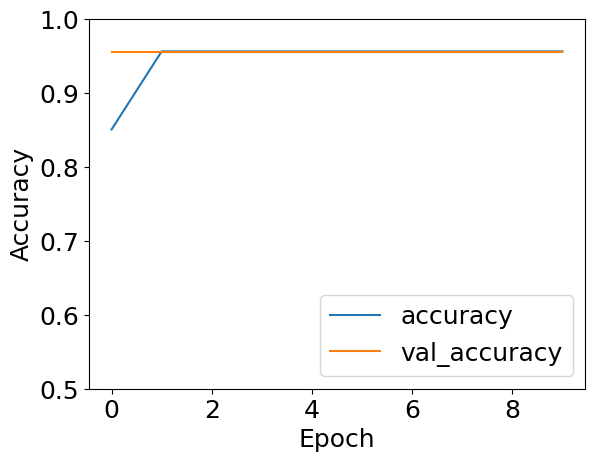

4/4 - 2s - 593ms/step - accuracy: 0.9555 - loss: 0.7100
Model accuracy: 0.9554621577262878


<Sequential name=sequential_10, built=True>

In [57]:
epochs = 10
shuffle = False

# Train 
training(ds_train,ds_val,ds_test,epoch=epochs,model_save_name="model2", model_version=CNN1())


# 6. Evaluate the model in test dataset and plot some diagnostic

In the next cells evaluate the trained model 1 on the test set, producing also the confusion matrix. Moreover, plot the history of the loss and accuracy. ROC

In [21]:
def get_cfmatrix(test_ds,model):
    """Plots the confusion matrix for the model compared to the test labels"""
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # iterate over the dataset
    for image_batch, labels in test_ds:   # use dataset.unbatch() with repeat
        # append true labels
        y_true.extend(labels.numpy())
        # compute predictions
        preds = model.predict(image_batch)
        # append predicted labels
        y_pred.extend((preds > 0.5).astype(int).flatten())


#     # convert the true and predicted labels into tensors
#     correct_labels = tf.concat([item for item in y_true], axis = 0)
#     predicted_labels = tf.concat([item for item in y_pred], axis = 0)
   
    cf_matrix = metrics.confusion_matrix(y_true, y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
    disp.plot()
    plt.show()


4/4 - 2s - 590ms/step - accuracy: 0.9555 - loss: 0.1863
Model accuracy: 0.9554621577262878
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


2024-06-18 09:33:02.991206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


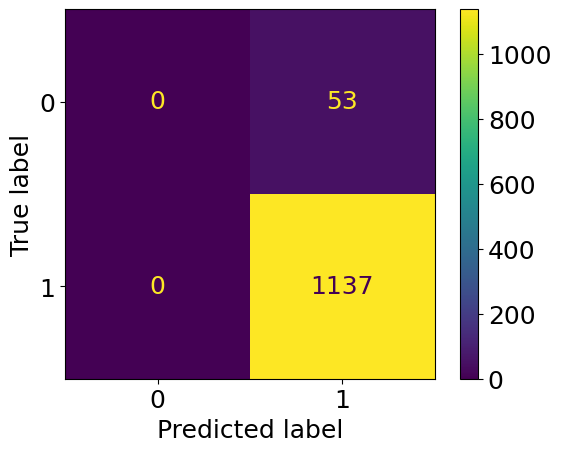

In [20]:
##Load dataset
mod = tf.keras.models.load_model('model2.keras')
test_loss, test_acc = mod.evaluate(ds_test, verbose=2)
print(f"Model accuracy: {test_acc}")
get_cfmatrix(ds_test,mod)

So the model evidently decided that classifying everything as a unbarred galaxies provided a good enough performance. We will use data augmentation to make the classes more balanced

# Data augmentation

In [30]:
from scipy.ndimage import rotate

#rotation
def rotate_img(dst_path, img_path, file_name,rot_deg):
        dst_img=img_path+file_name+".fits"

        hdulist= fits.open(dst_img)

        #extract image data
        dat = hdulist[1].data
        
        #Rotate image
        dat_rot= rotate(dat, rot_deg)
        
        hdulist[1].data = dat_rot
        
        dst_path= f"{dst_path}{file_name}_{rot_deg}.fits"
#         hdulist.writeto(dst_path, overwrite= True)
    



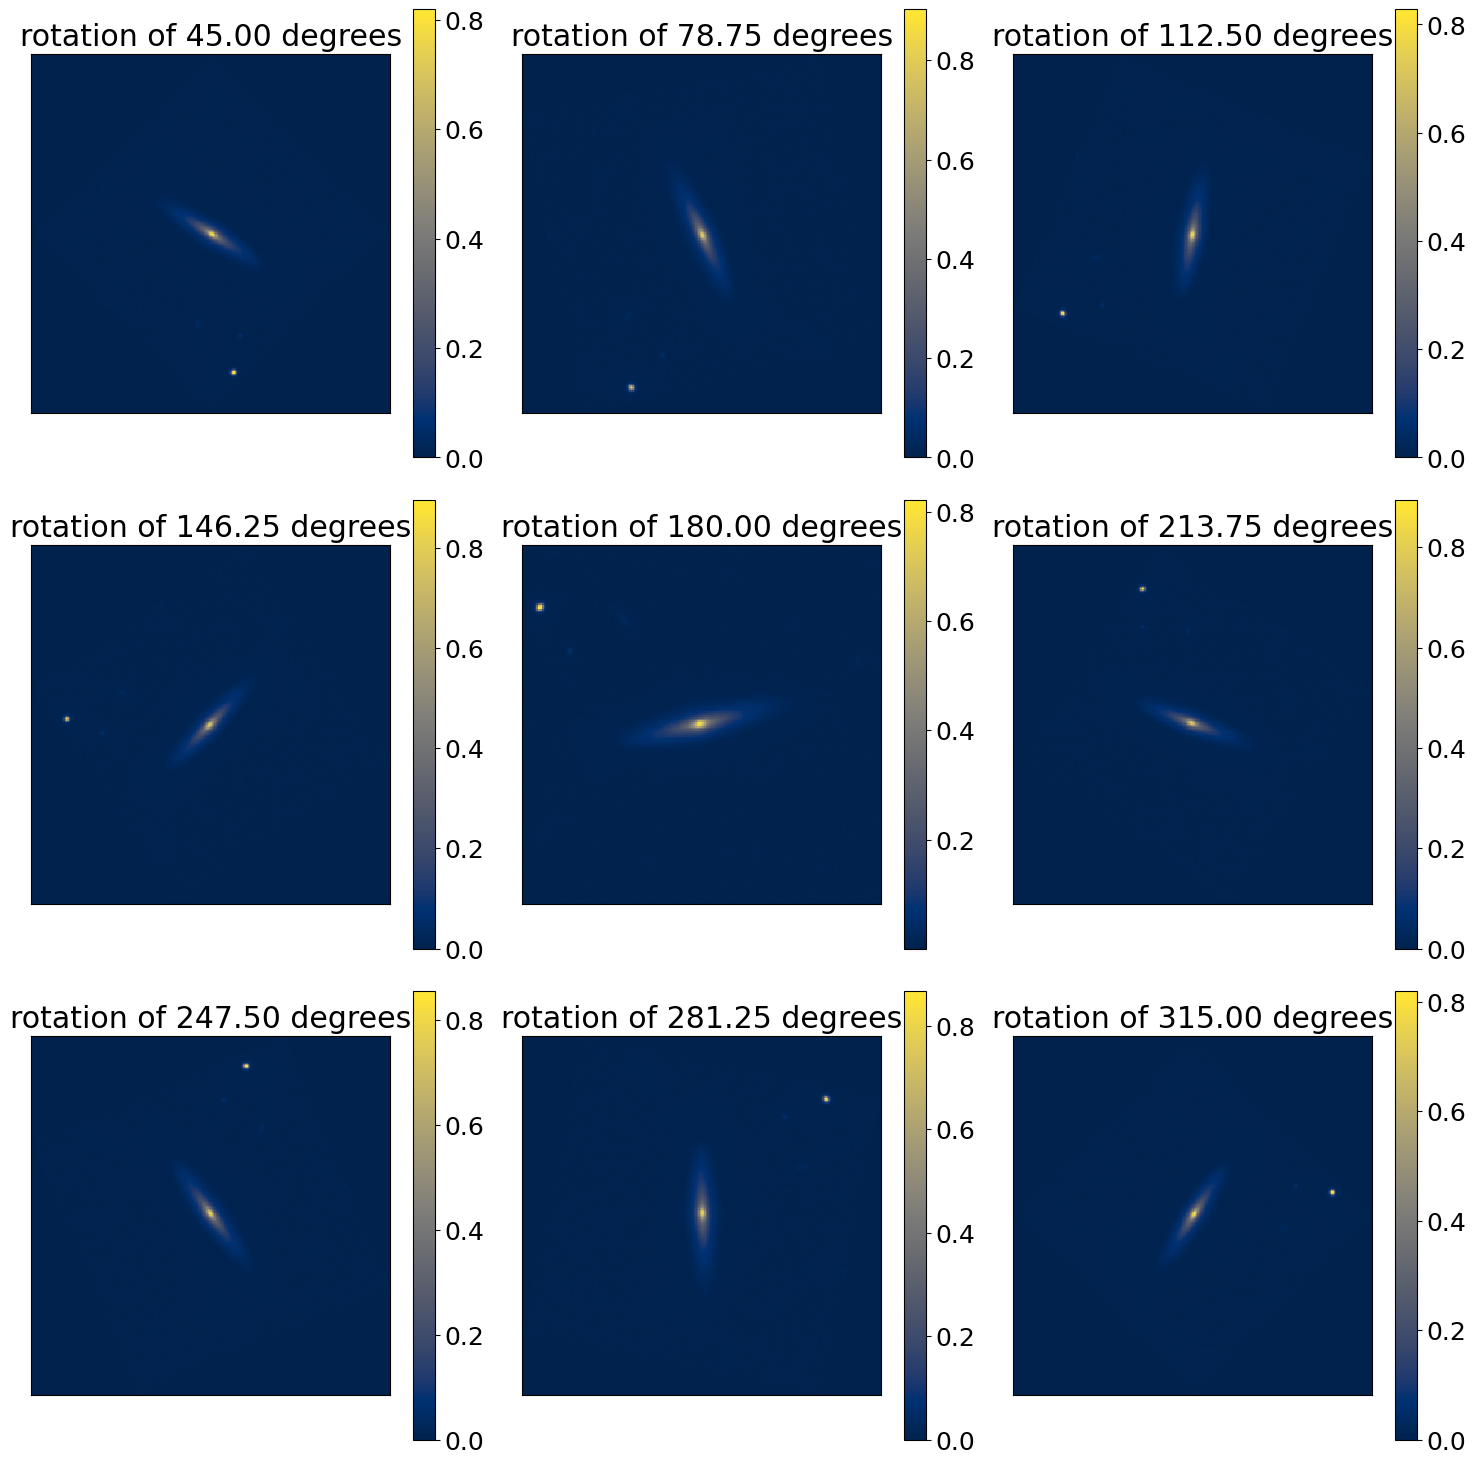

In [24]:
#Test some rotations
img_dir=bulk_dir+'train_img/'
names_bars= [path.stem for path in list(Path(img_dir).glob("Yb_*"))]

dst_img=img_dir+names_bars[5]+".fits"

hdulist= fits.open(dst_img)

#extract image data
dat = hdulist[1].data

#List rotations to check
rots= np.linspace(45,315,9)

fig= plt.figure(figsize=(15,15))
for i,deg in enumerate(rots):
    dat_rot= rotate(dat,deg)
    
    ax= fig.add_subplot(3,3,i+1)
    im= ax.imshow(dat_rot, interpolation='none', origin="lower", cmap='cividis')
    ax.set_title(f"rotation of {deg:.2f} degrees")
    plt.colorbar(im)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
fig.tight_layout()
plt.show()

We generate 4 new images for every barred galaxy via rotations

In [26]:
#generate augemented data. We rotate all images 4 times
#range to generate numbers: 30-50 55-75 80-100 105-125

img_dir=bulk_dir+'train_img/'
names_bars= [path.stem for path in list(Path(img_dir).glob("Yb_*"))]
n_bars= len(names_bars)

rot_1=randint(30,50,n_bars)
rot_2=randint(55,75,n_bars)
rot_3=randint(80,100,n_bars)
rot_4=randint(105,125,n_bars)

for i,name in tqdm(enumerate(names_bars)):
    rotate_img(img_dir, img_dir, name,rot_1[i])
    rotate_img(img_dir, img_dir, name,rot_2[i])
    rotate_img(img_dir, img_dir, name,rot_3[i])
    rotate_img(img_dir, img_dir, name,rot_4[i])
    
    

166it [00:15, 10.42it/s]


In [27]:
#repeat for validation data

img_dir=bulk_dir+'val_img/'
names_bars= [path.stem for path in list(Path(img_dir).glob("Yb_*"))]
n_bars= len(names_bars)

rot_1=randint(30,50,n_bars)
rot_2=randint(55,75,n_bars)
rot_3=randint(80,100,n_bars)
rot_4=randint(105,125,n_bars)

for i,name in tqdm(enumerate(names_bars)):
    rotate_img(img_dir, img_dir, name,rot_1[i])
    rotate_img(img_dir, img_dir, name,rot_2[i])
    rotate_img(img_dir, img_dir, name,rot_3[i])
    rotate_img(img_dir, img_dir, name,rot_4[i])
    
    

42it [00:08,  4.73it/s]


In [29]:
#and test data

img_dir=bulk_dir+'test_img/'
names_bars= [path.stem for path in list(Path(img_dir).glob("Yb_*"))]
n_bars= len(names_bars)

rot_1=randint(30,50,n_bars)
rot_2=randint(55,75,n_bars)
rot_3=randint(80,100,n_bars)
rot_4=randint(105,125,n_bars)

for i,name in tqdm(enumerate(names_bars)):
    rotate_img(img_dir, img_dir, name,rot_1[i])
    rotate_img(img_dir, img_dir, name,rot_2[i])
    rotate_img(img_dir, img_dir, name,rot_3[i])
    rotate_img(img_dir, img_dir, name,rot_4[i])
    
    

53it [00:07,  6.84it/s]


# Test our data augmentation

In the generation of the dataset the unbarred galaxies were sampled such that there were equal amounts of barred and unbarred galaxies


In [133]:
#Load the dataset
tfds_name = "augment_ds:1.0.0"
datasets_path = '/Users/users/asselt/tensorflow_datasets/'
batch_size = 64

In [134]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    tfds_name,
    data_dir=datasets_path,
    split=["train", "val", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

dataset_size = ds_info.splits["train"].num_examples
print("Num_examples dataset:", dataset_size)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(dataset_size)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Num_examples dataset: 1660


In [135]:
ds_train = ds_train.prefetch(buffer_size=16)
ds_val = ds_val.prefetch(buffer_size=16)
ds_test = ds_test.prefetch(buffer_size=16)

In [75]:
print(ds_train)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 196, 196, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 194, 194, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 97, 97, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 95, 95, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 93, 93, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 44, 44, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 247808)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │    15,859,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,015,713 (61.10 MB)

 Trainable params: 16,015,713 (61.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5109 - loss: 1.6855 - val_accuracy: 0.5000 - val_loss: 0.7081
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5043 - loss: 0.6937 - val_accuracy: 0.5476 - val_loss: 0.6603
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6582 - loss: 1.9843 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4994 - loss: 7.9814 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 5/10
25/26 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5119 - loss: 7.7809
Epoch 5: saving model to /Users/users/asselt/dataserver/BULK/ADS/CNN_pred//cp-0005.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5111 - loss: 7.7950 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4960 - loss: 8.0348 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5055 - loss: 7

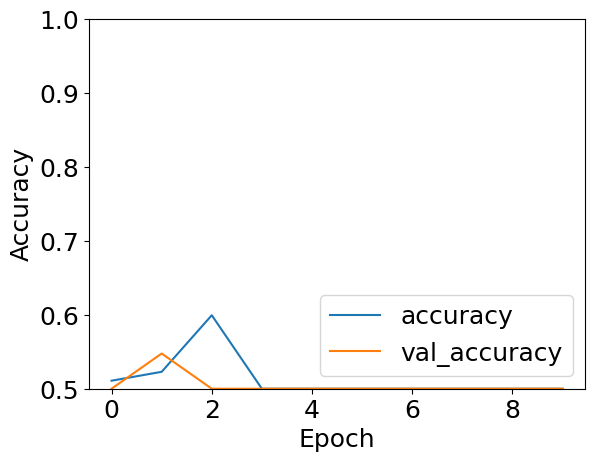

9/9 - 3s - 307ms/step - accuracy: 0.5000 - loss: 7.9712
Model accuracy: 0.5


<Sequential name=sequential_5, built=True>

In [50]:
Model_test= CNN1((200,200,1))
training(ds_train,ds_val,ds_test,epoch=10,model_save_name="model_test", model_version=Model_test,batch_size=batch_size,size=dataset_size)

9/9 - 3s - 332ms/step - accuracy: 0.5000 - loss: 7.9712
Model accuracy: 0.5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


2024-06-18 14:02:29.643924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


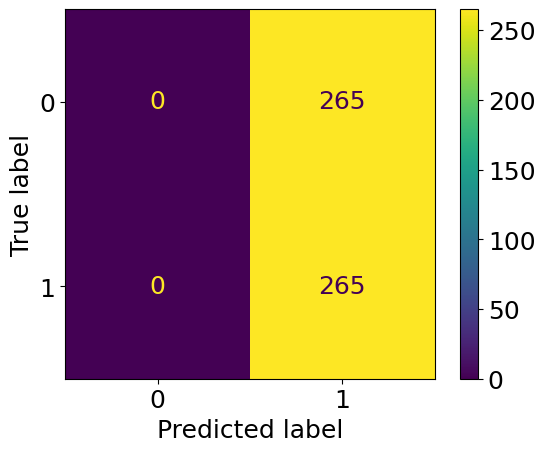

In [51]:
##Load dataset
mod = tf.keras.models.load_model('model_test.keras')
test_loss, test_acc = mod.evaluate(ds_test, verbose=2)
print(f"Model accuracy: {test_acc}")
get_cfmatrix(ds_test,mod)

This model still only classifies as one type of galaxy (barred), so the model still does not work well. However, we now see that our metrics give a representative metric of how well the classification works. We will try a new model with the augmented dataset.

# New model

In [40]:
def CNN2():
    """"More extensive model"""
    CNN = models.Sequential()
    CNN.add(layers.Conv2D(16, (9, 9),activation='relu', input_shape=(200, 200,1)))
    CNN.add(layers.Conv2D(32, (5, 5),activation='relu'))
    CNN.add(layers.BatchNormalization(axis=-1))
    CNN.add(layers.MaxPooling2D((2, 2)))
    CNN.add(layers.Dropout(0.3))
    
    CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
    CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
    CNN.add(layers.BatchNormalization(axis=-1))
    CNN.add(layers.MaxPooling2D((2, 2)))
    CNN.add(layers.Dropout(0.3))
    
    CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
    CNN.add(layers.Conv2D(128, (1, 1), activation='relu'))
    CNN.add(layers.BatchNormalization(axis=-1))
    CNN.add(layers.Dropout(0.3))

    CNN.add(layers.Flatten())
    CNN.add(layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
    CNN.add(layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
    CNN.add(layers.Dense(1, activation='sigmoid'))
    CNN.summary()

    CNN.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return CNN

model_2= CNN2()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 192, 192, 16)   │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 188, 188, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 188, 188, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 43, 43, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 43, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 236672)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    30,294,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,463,297 (116.21 MB)

 Trainable params: 30,462,849 (116.21 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.5429 - loss: 11.0270 - val_accuracy: 0.5119 - val_loss: 8.8919
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.7709 - loss: 8.1823 - val_accuracy: 0.4976 - val_loss: 6.1497
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.8339 - loss: 5.3056 - val_accuracy: 0.5000 - val_loss: 4.5116
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.8721 - loss: 3.3334 - val_accuracy: 0.5000 - val_loss: 3.4276
Epoch 5/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8792 - loss: 2.5006
Epoch 5: saving model to /Users/users/asselt/dataserver/BULK/ADS/CNN_pred//cp-0005.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.8785 - loss: 2.4929 - val_accuracy: 0.5095 - val_loss: 2.6620
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.8589 - loss: 2.1936 - val_accuracy: 0.5000 - val_loss: 2.4532
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.9022 -

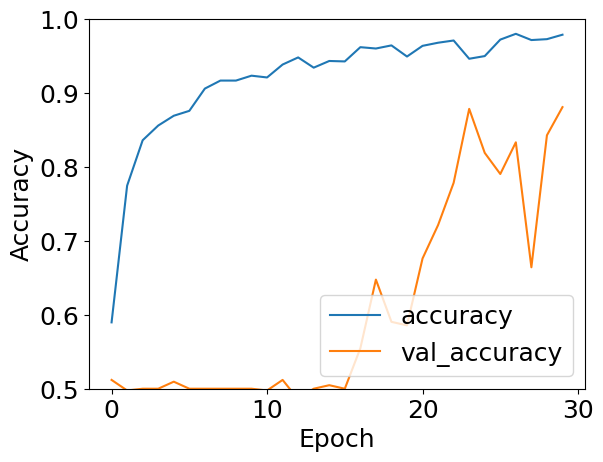

9/9 - 3s - 307ms/step - accuracy: 0.8792 - loss: 1.1539
Model accuracy: 0.8792452812194824


<Sequential name=sequential_1, built=True>

In [41]:
training(ds_train,ds_val,ds_test,epoch=30,model_save_name="model_aug", model_version=model_2,batch_size=batch_size,size=dataset_size)

9/9 - 3s - 355ms/step - accuracy: 0.8792 - loss: 1.1539
Model accuracy: 0.8792452812194824
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


2024-06-18 11:40:00.387391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


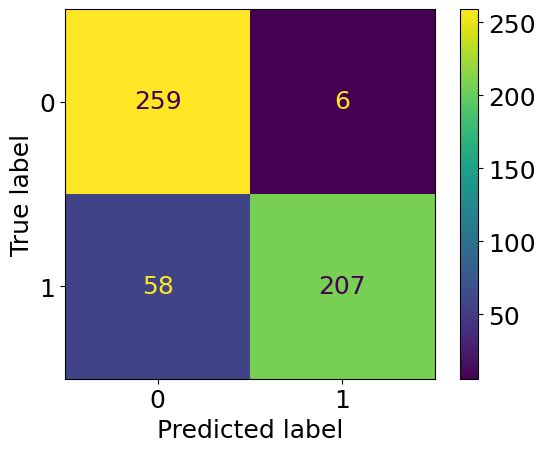

In [42]:
##Load dataset
mod = tf.keras.models.load_model('model_aug.keras')
test_loss, test_acc = mod.evaluate(ds_test, verbose=2)
print(f"Model accuracy: {test_acc}")
get_cfmatrix(ds_test,mod)

The history of the training seems a little irregular. I often had the issues with my models that the training and/or accuracy would drop quite steeply and I'm not sure why it does this. However, we still acquire a nearly 88% accuracy and a 78% recall. While this is not an amazing result, it is still acceptable. We also see that we have hardly any false positives, which means that the classification of the barred galaxies should be fairly reliable. We only should expect to miss out on ~20% of our barred galaxies.

# 7. Make prediction on rest of HSC

Produce the catalog of HSC to download and predict.

1. Create dataset (Do not shuffle).
2. Read dataset (Do not shuffle).
3. Load best model.
4. Predict on data.
5. Analyse bar/non-bar galaxies as a function different physical properties.



The dataset was prepared in the same way we prepared our training dataset. The data was first normalised and then it was resized to (200,200,1)

In [136]:
#Load the dataset
tfds_name = "gama_set:1.0.0"
datasets_path = '/Users/users/asselt/tensorflow_datasets/'
batch_size=64

(ds_pred), ds_info = tfds.load(
    tfds_name,
    data_dir=datasets_path,
    shuffle_files=False,
    as_supervised=False,
    with_info=True,
)

dataset_size = ds_info.splits["train"].num_examples
print("Num_examples dataset:", dataset_size)

def preprocessing(image):
    return image['image'], image['label']

ds_pred = ds_pred['train'].map(preprocessing)
ds_pred = ds_pred.cache()
ds_pred = ds_pred.batch(batch_size)
ds_pred = ds_pred.prefetch(tf.data.experimental.AUTOTUNE)

Num_examples dataset: 1217


In [137]:
#Load model
model_pred = tf.keras.models.load_model('model_aug.keras')
gama_pred = []  # store predicted labels
names_gama=[]
# iterate over the dataset
for image,name in ds_pred:   # use dataset.unbatch() with repeat
    # compute predictions
    preds = model_pred.predict(image)
    # append predicted labels
    gama_pred.extend((preds > 0.5).astype(int).flatten())
    names_gama.extend(name)

print(len(names_gama))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1217


2024-06-18 20:42:24.037825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [138]:
print(f"Number of bars is {np.sum(gama_pred)} out of {len(gama_pred)}")
print(f"Which gives a bar/unbarred ratio of {np.sum(gama_pred)/(len(gama_pred)-np.sum(gama_pred))} compared to a ratio of  0.0459 in our training dataset ")

Number of bars is 51 out of 1217
Which gives a bar/unbarred ratio of 0.04373927958833619 compared to a ratio of  0.0459 in our training dataset 


We see that the ratio of classified barred is very similar the one we obtained in the galaxy zoo catalog data. This is a good first analysis to see if our model performs as expected. However, we do remember that the recall was less than 80%, so we should expect that we missed quite a few barred galaxy in our classification.

In [83]:
gama_path = bulk_dir+"HSC_GAMA09/"
names_gama = names_glob=[path.stem for path in list(Path(data_dir).glob("*"))]

In [71]:
Table_gama= Table.read(bulk_dir+"gama09_selected.fits",format="fits")

print(Table_gama.columns)

<TableColumns names=('hsc_id','ra','dec','redshift','stellar_mass','stellar_mass_err','sfr','sfr_err','agn_luminosity','agn_luminosity_err','agn_fraction','agn_fraction_err')>


In [73]:
#Sort the table to match our classification order
Table_gama.sort(['hsc_id'])

In [76]:
#Append the classification to our table
Table_gama.add_column(col=gama_pred, name= "prediction")

In [80]:
df_gama= Table_gama.to_pandas()

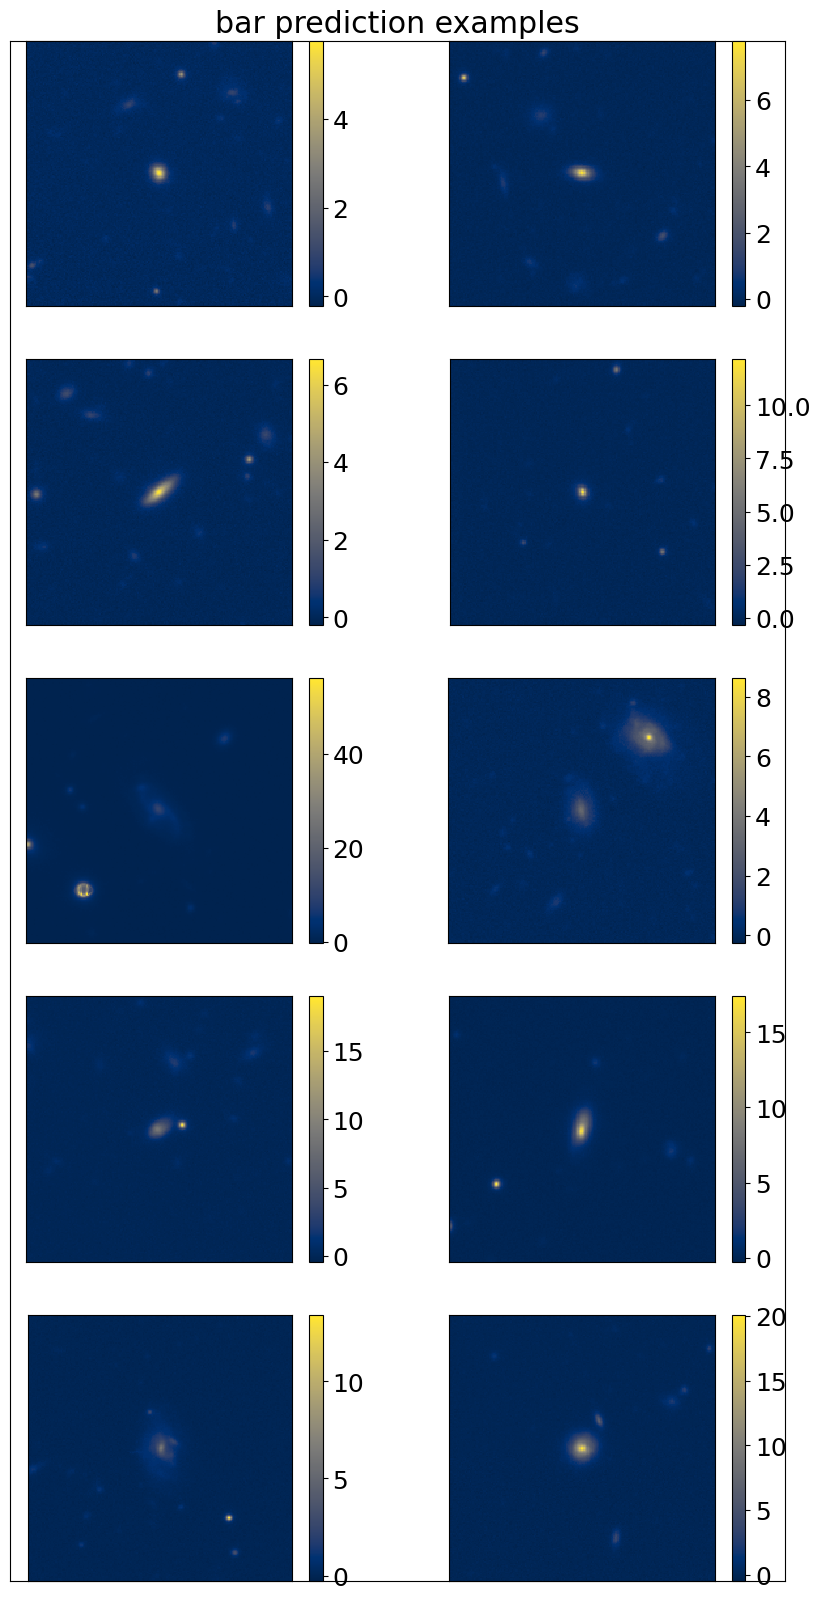

In [88]:
#sample 10 bar classifications
sample_class= df_gama[df_gama["prediction"]==1].sample(10)

plt.figure(figsize=(10,20))
plt.title("bar prediction examples")
plt.xticks([])
plt.yticks([])
for i,name in enumerate(sample_class["hsc_id"]):
    hdulist= fits.open(gama_path+str(name)+".fits")
    dat = hdulist[1].data
    plt.subplot(5,2,i+1)
    im= plt.imshow(dat, interpolation='none', origin="lower", cmap='cividis')
    plt.colorbar(im)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)


plt.show()
    

Most of these galaxies are too hard to resolve or have other bright sources to visually inspect if they are indeeed barred galaxies or not. A lot of them seems a little bit dubious if we're being honest.


## Comparison with other properties

In [113]:
df_bars =df_gama[df_gama["prediction"]==1]

<function matplotlib.pyplot.show(close=None, block=None)>

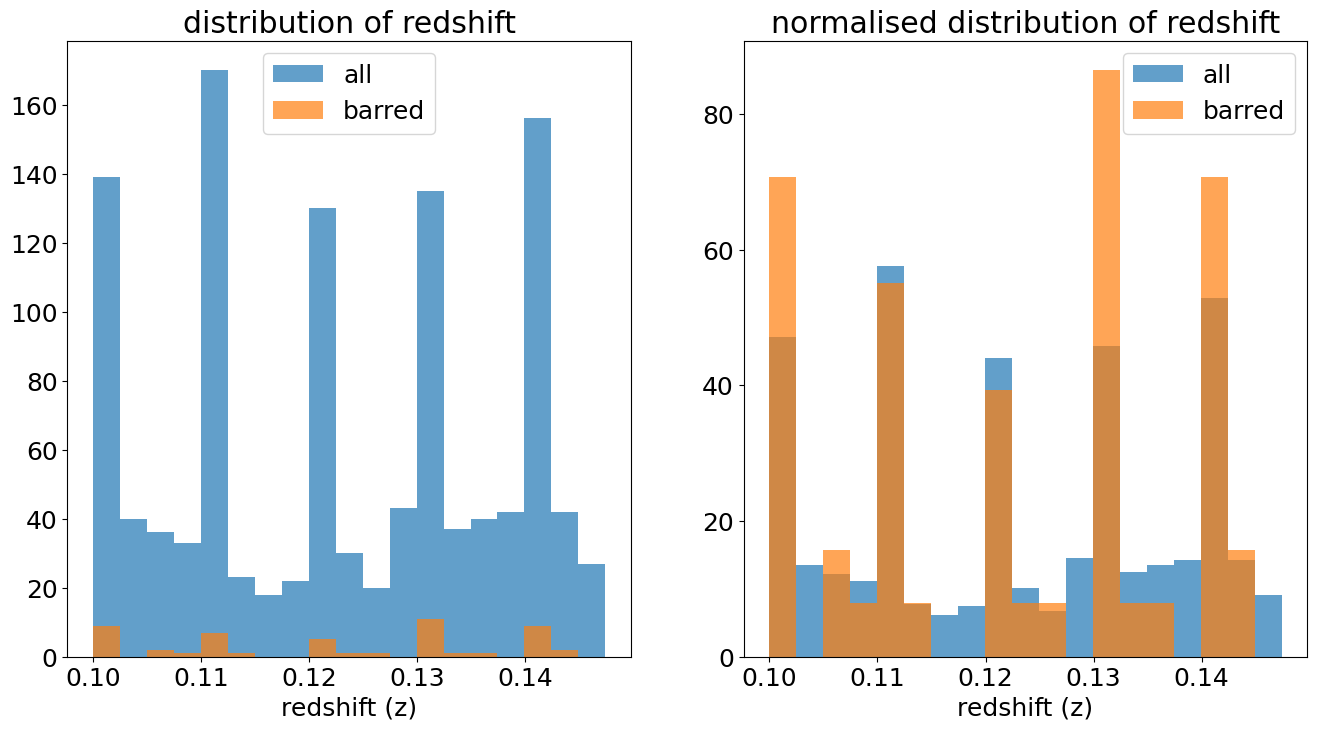

In [107]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2)
z_min=np.min(df_gama['redshift'])
z_max=np.max(df_gama['redshift'])
bins_def = np.arange(z_min,z_max,((z_max-z_min)/20))
ax[0].hist(df_gama['redshift'],label="all",alpha=0.7,bins=bins_def)
ax[0].hist(df_bars['redshift'], label="barred",alpha=0.7,bins=bins_def)
ax[0].set_xlabel("redshift (z)")
ax[0].legend()
ax[0].set_title("distribution of redshift")
ax[1].hist(df_gama['redshift'],label="all",density=True,alpha=0.7,bins=bins_def)
ax[1].hist(df_bars['redshift'], label="barred",density=True,alpha=0.7,bins=bins_def)
ax[1].set_xlabel("redshift (z)")
ax[1].legend()
ax[1].set_title("normalised distribution of redshift")
plt.show

The barred classifications seem to behave similarly to the other data. However, the clear peaks in the data at certain redshifts make it difficult to evaluate any relation. We're also only looking at galaxies at a very short interval which again makes it difficult to give a more detailed analysis. 

We also note that the redshift range of the prediction data is on the high end of the radshift range of the training data. This could lead to difficulty with accurately classifying the data. However, we did see that we still found suffient samples for our trainingset for these ranges.

In [114]:
#Check agns 
non_bar_df =df_gama[df_gama["prediction"]==0]

nb_agn= non_bar_df[non_bar_df['agn_fraction']>=0.5]

yb_agn= df_bars[df_bars['agn_fraction']>=0.5]

print(f"The fraction of AGNS in barred galaxies is {len(yb_agn)/len(df_bars)} \n and in unbarred galaxies it's {len(nb_agn)/len(non_bar_df)} ")
print(f"The average AGN fraction in barred galaxies is {np.mean(df_bars['agn_fraction'])} \n and in unbarred galaxies it's {np.mean(non_bar_df['agn_fraction'])} ")

The fraction of AGNS in barred galaxies is 0.0 
 and in unbarred galaxies it's 0.002572898799313894 
The average AGN fraction in barred galaxies is 0.03296871393309807 
 and in unbarred galaxies it's 0.034414010142408594 


The AGN fraction of barred and unbarred galaxies seem to be very comparable

<function matplotlib.pyplot.show(close=None, block=None)>

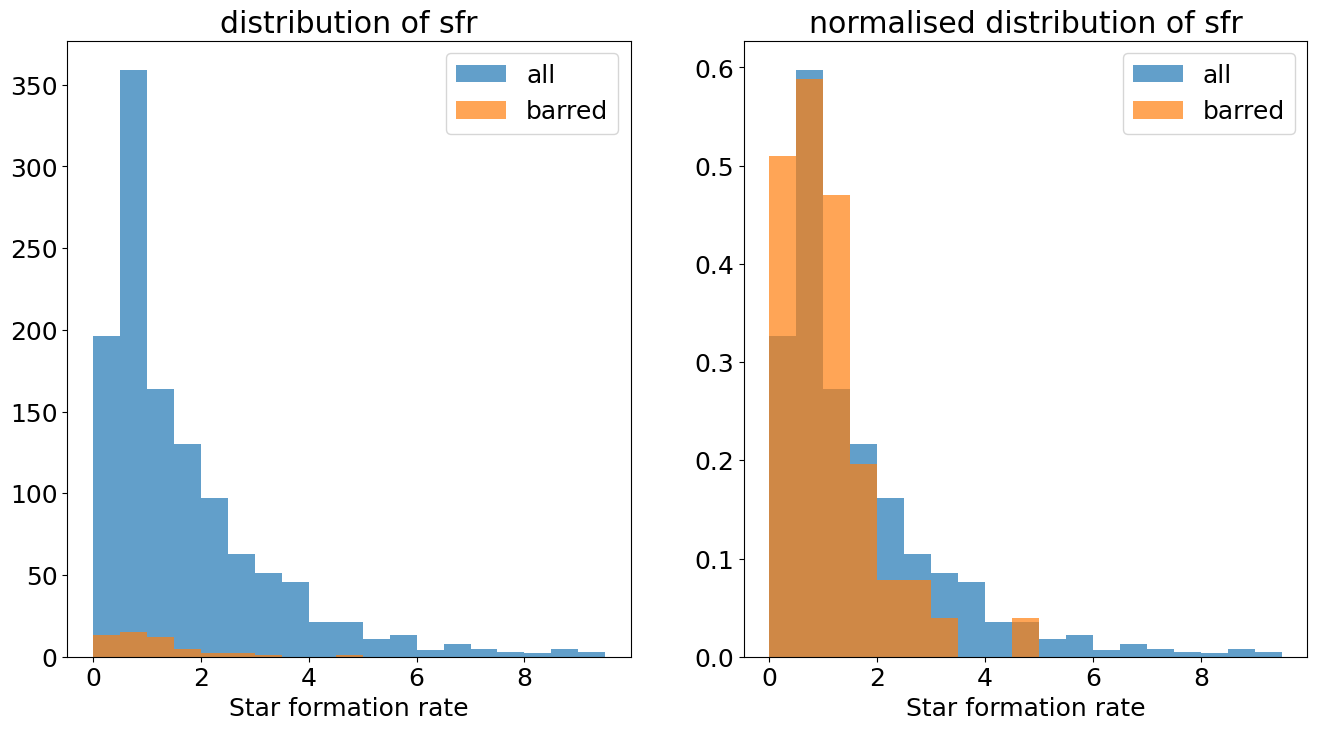

In [116]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2)
x_min=0
x_max=10
bins_def = np.arange(x_min,x_max,((x_max-x_min)/20))
ax[0].hist(df_gama['sfr'],label="all",alpha=0.7,bins=bins_def)
ax[0].hist(df_bars['sfr'], label="barred",alpha=0.7,bins=bins_def)
ax[0].set_xlabel("Star formation rate")
ax[0].legend()
ax[0].set_title("distribution of sfr")
ax[1].hist(df_gama['sfr'],label="all",density=True,alpha=0.7,bins=bins_def)
ax[1].hist(df_bars['sfr'], label="barred",density=True,alpha=0.7,bins=bins_def)
ax[1].set_xlabel("Star formation rate")
ax[1].legend()
ax[1].set_title("normalised distribution of sfr")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

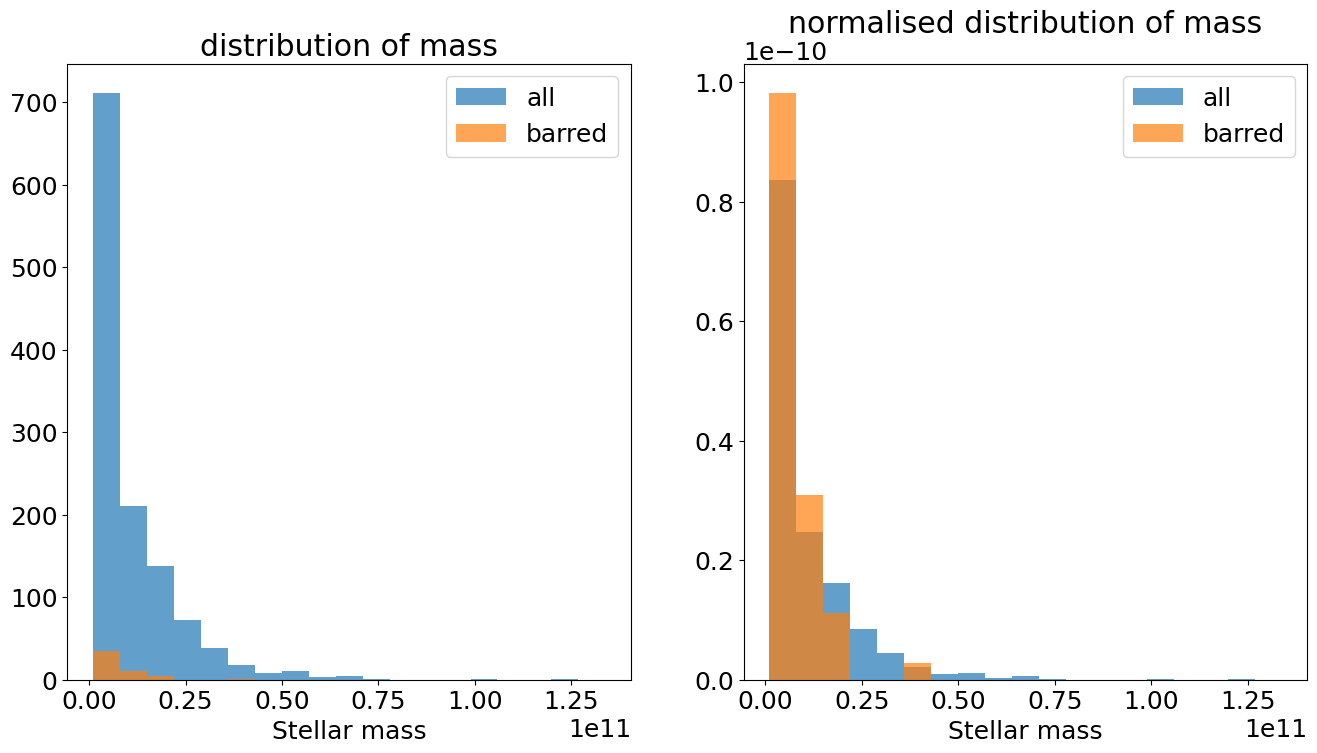

In [117]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2)
x_min=np.min(df_gama['stellar_mass'])
x_max=np.max(df_gama['stellar_mass'])
bins_def = np.arange(x_min,x_max,((x_max-x_min)/20))
ax[0].hist(df_gama['stellar_mass'],label="all",alpha=0.7,bins=bins_def)
ax[0].hist(df_bars['stellar_mass'], label="barred",alpha=0.7,bins=bins_def)
ax[0].set_xlabel("Stellar mass")
ax[0].legend()
ax[0].set_title("distribution of mass")
ax[1].hist(df_gama['stellar_mass'],label="all",density=True,alpha=0.7,bins=bins_def)
ax[1].hist(df_bars['stellar_mass'], label="barred",density=True,alpha=0.7,bins=bins_def)
ax[1].set_xlabel("Stellar mass")
ax[1].legend()
ax[1].set_title("normalised distribution of mass")
plt.show

Both stellar mass and the star formation rate do not seem to exhibit any trends that do not reflect the general distribution

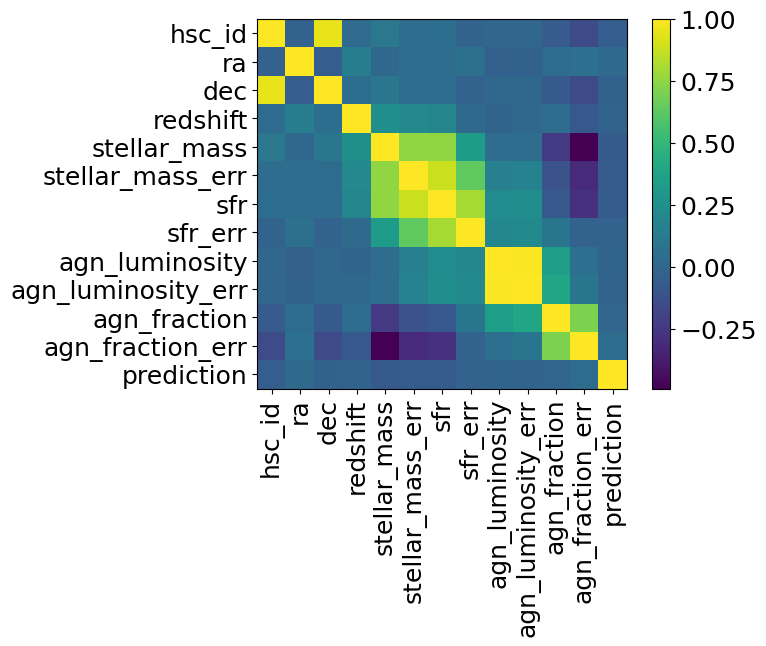

In [149]:
correlation= df_gama.corr()

fig = plt.figure()
plt.imshow(correlation)
plt.colorbar()
plt.xticks(range(len(correlation)), df_gama.columns,rotation=90)
plt.yticks(range(len(correlation)), df_gama.columns)
plt.show()

# 7. Discussion

- Summary and discussion of your network, training and performance (how did you choose your architecture? What was the training strategy? How did you find the best model?, Which redshift are you using for training? What happends if you apply to higher redshift (visualize some data)...).
- Is your model overfitting/underfitting? How do you know?
- How to prevent overfitting/underfitting?

- Discuss your results on the prediction data
- Did you find any correlation between bar/non-bar galaxies and any physical property?


The final model has an accuracy of ~88% and a recall of 78%. On first glance it seems to provide relatively accurate labels for the barred galaxies with the test data only showing a ~3% error on this. I am unsure how reliable these metrics are since the test dataset also contains augmented images. I found it difficult to strike a balance between not testing the model on the "same" (but rotated) image multiple times and testing the data on a big enough test set which also contained a reasonable amount of barred galaxies.

The progession of the train and val accuracy of the model shows some interesting behavior but in general does not seem to be overfitting on the data. In the cells below I did test the same model but trained on more epochs but this model dropped very steeply in accuracy near the end and seemingly did start overfitting, hence why we limited our model to 30 epochs. 

I also tested a model that I got from Berta during my thesis to see if this would provided reasonable results and so I had something to compare it with. This model did get better accuracy and had a generally better looking training curve than my own model but I decided that it would not be perhaps be slightly unethical to use this model any further. I however did use the architecture to get an idea of the layers I could use. This was especially useful to get a feeling for the kernel size and on how to use the dropout layer, as I had not used this myself before.

To help with overfitting it is possible to make your model stop early, however I think the easiest method is to make sure to monitor the training curve of your model. If the training accuracy keeps increasing while your validation accuracy is going down, then it is clear that the model is overfitting. Another tell-tale sign is if your test accuracy is significantly lower than the validation accuracy. This did not apppear to be an issue for my model. 

The model was trained over a larger redshift range than the prediction data gives. As mentioned before, the prediction data leans on the far end of the redshift range that was used for training. If we had enough data, it might have been good to sample more from this part of the range, since higher redshift galaxies will usually be more difficult to resolve. However, since we already had very few barred galaxies this was not really an option

In order to inspect our prediction labels I would have to inspect each image more indivually with adjusted vmin and vmax ranges, in an attempt to better resolve any features it might display. This is not really possible with the interest of time. On first glance quite a few seem like very small images and I can not readily identify many bars.

I again did not have the time to do any error analysis on my bars and subsequently any of the possible relations between bars and other properties. The distributions as I have plotted them now do not seem to show any signs of a relation with bars as the distribution is very similar for the barred galaxies and the general dataset. A quick test of plotting the correlation matrix of our dataframe also does not show any relation with the other parameters.


# 8. Repeat the same steps for a second network

Optional. Compare results with previous network

/Software/users/modules/7/software/anaconda3/2023.03/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 192, 192, 16)   │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 188, 188, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 188, 188, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 43, 43, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 43, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 236672)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    30,294,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,463,297 (116.21 MB)

 Trainable params: 30,462,849 (116.21 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.5448 - loss: 8.8434 - val_accuracy: 0.5000 - val_loss: 8.3282
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.7548 - loss: 8.2392 - val_accuracy: 0.5000 - val_loss: 6.2873
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.8259 - loss: 5.6035 - val_accuracy: 0.5000 - val_loss: 4.3769
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.8360 - loss: 3.8411 - val_accuracy: 0.5000 - val_loss: 4.4336
Epoch 5/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8585 - loss: 2.7257
Epoch 5: saving model to /Users/users/asselt/dataserver/BULK/ADS/CNN_pred//cp-0005.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.8582 - loss: 2.7131 - val_accuracy: 0.5000 - val_loss: 5.0101
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.8765 - loss: 2.1761 - val_accuracy: 0.5000 - val_loss: 2.9223
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.8756 - 

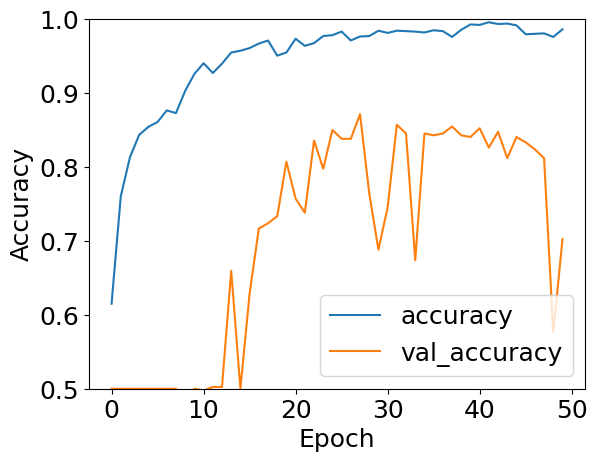

9/9 - 3s - 296ms/step - accuracy: 0.7038 - loss: 1.3152
Model accuracy: 0.703773558139801


<Sequential name=sequential_2, built=True>

In [45]:
#Same as final model but more epochs
model_3= CNN2()
training(ds_train,ds_val,ds_test,epoch=50,model_save_name="model_aug_50", model_version=model_3,batch_size=batch_size,size=dataset_size)

9/9 - 3s - 346ms/step - accuracy: 0.7038 - loss: 1.3152
Model accuracy: 0.703773558139801
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


2024-06-18 13:44:24.421673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


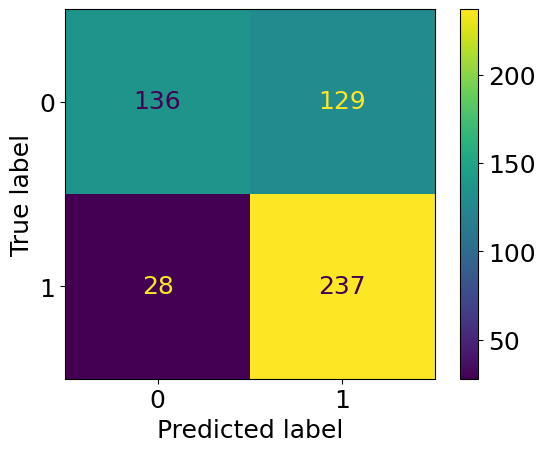

In [46]:
##Load dataset
mod = tf.keras.models.load_model('model_aug_50.keras')
test_loss, test_acc = mod.evaluate(ds_test, verbose=2)
print(f"Model accuracy: {test_acc}")
get_cfmatrix(ds_test,mod)

The model run for 50 epochs shows some very clear overfitting

In [25]:
#Model from thesis, created by berta
#Only used to check if I was able to produce any reasonable results

def create_model_3(input_dim, load_weights=False, filename_model=''):
    """Creates a Keras model with layers.

    Returns:
    A keras.Model
    Architecture created by Berta Margalef
    """

    inputs = Input(shape = input_dim)        # Image input (real sample)

#     data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3))])

#     x = data_augmentation(inputs)
    x = models.Sequential()



    x.add(Conv2D(32, (11, 11), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02),input_shape=input_dim))
    x.add(LeakyReLU(0.2))
    x.add(BatchNormalization())
    x.add(Dropout(0.5))

    x.add(Conv2D(64, (9, 9), strides=(2, 2), padding='same'))
    x.add(LeakyReLU(0.2))
    x.add( BatchNormalization())
    x.add(Dropout(0.5))

    x.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    x.add(LeakyReLU(0.2))
    x.add(BatchNormalization())
    x.add(Dropout(0.5))

    x.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    x.add(LeakyReLU(0.2))
    x.add(BatchNormalization())
    x.add(Dropout(0.5))


    x.add(Flatten())
    x.add(Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
    x.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
    x.add(Dense(1, activation='sigmoid'))



    # Compile Model
    learning_rate = 0.001
    optimizer = 'adam'
    metrics = ['accuracy']
    loss = 'binary_crossentropy'
    x.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    x.summary()

    if load_weights:
        print('Loading weights')
        print(filename_model)
        x.load_weights(filename_model)

    return x

model_3= create_model_3((200,200,1), filename_model="model_thesis")

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 100, 100, 32)   │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 50, 50, 64)     │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 25, 25, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 13, 13, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,442,945 (13.13 MB)

 Trainable params: 3,441,985 (13.13 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9329 - loss: 0.4144 - val_accuracy: 0.8524 - val_loss: 0.5636
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9226 - loss: 0.4406 - val_accuracy: 0.8548 - val_loss: 0.5783
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9419 - loss: 0.4124 - val_accuracy: 0.8476 - val_loss: 0.6474
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9401 - loss: 0.3937 - val_accuracy: 0.8405 - val_loss: 0.6655
Epoch 5/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9379 - loss: 0.3900
Epoch 5: saving model to /Users/users/asselt/dataserver/BULK/ADS/CNN_pred//cp-0005.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9379 - loss: 0.3906 - val_accuracy: 0.8333 - val_loss: 0.6634
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9364 - loss: 0.4351 - val_accuracy: 0.8619 - val_loss: 0.6328
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9479 - loss: 0

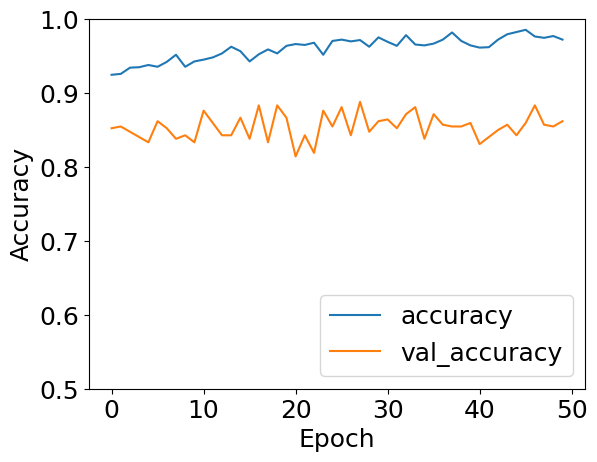

19/19 - 2s - 97ms/step - accuracy: 0.8975 - loss: 0.6123
Model accuracy: 0.8974789977073669


<Sequential name=sequential_12, built=True>

In [27]:
training(ds_train,ds_val,ds_test,epoch=50,model_save_name="model_thesis", model_version=model_3,batch_size=batch_size,size=dataset_size)

9/9 - 1s - 127ms/step - accuracy: 0.8660 - loss: 0.8736
Model accuracy: 0.8660377264022827
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


2024-06-18 10:35:28.362770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


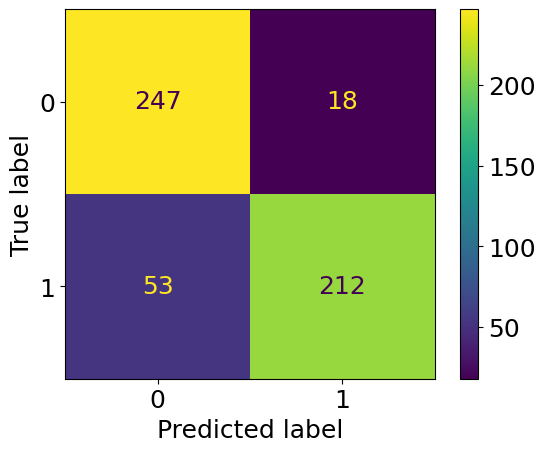

In [34]:
##Load dataset
mod = tf.keras.models.load_model('model_thesis.keras')
test_loss, test_acc = mod.evaluate(ds_test, verbose=2)
print(f"Model accuracy: {test_acc}")
get_cfmatrix(ds_test,mod)